In [ ]:
!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc
!wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!pip install polytope


In [ ]:
l_passing_car = 4
l_our_car   = 4.5
destination = 300
crossroad = 50

#CFTOC parameters
nz      = 2       # number of states
nu      = 1       # number of inputs
Ts      = 1       #s
N       = 20
v_max   = 50      #m/s
a_max = 4

In [ ]:
import numpy as np
from scipy.linalg import expm


A_c = np.array([[0, 1],
               [0, 0]])
B_c = np.array([[0],
              [1]])

#Discretize the system using ZOH:
Ts = 1

A_d = expm(A_c * Ts)

# Discretize B using integral of expm(A*t) * B
I = np.eye(A_c.shape[0])
A_inv = np.linalg.inv(A_c) if np.linalg.det(A_c) != 0 else np.linalg.pinv(A_c)
B_d = A_inv @ (A_d - I) @ B_c

In [ ]:
# car crossing road 50 metores from start. takes 5 seconds for car to cross. We have to either wait, or speed up. Constarints on input and speed

from pyomo.environ import *
import numpy as np

d_crossing = 50
t_crossing = 10
t_pass = 5

destination = 100

xL = np.array([0, 0])
xU = np.array([destination, v_max])
uL = -a_max
uU = a_max

N = 40
def cftoc(zbar0, t, comfort):
  model = ConcreteModel()
  model.N = N - t
  model.nx = np.size(A_d, 0)
  model.nu = np.size(B_d, 1)

  # length of finite optimization problem:
  model.tIDX = RangeSet(0, model.N)
  model.xIDX = RangeSet(0, model.nx - 1)
  model.uIDX = RangeSet(0, model.nu - 1)

  # these are 2d arrays:
  model.A = A_d
  model.B = B_d

  # Create state and input variables trajectory:
  def state_bounds(model, i, t):
    lower_bounds = [xL[0], xL[1]]
    upper_bounds = [xU[0], xU[1]]
    return (lower_bounds[i], upper_bounds[i])

  model.x = Var(model.xIDX, model.tIDX, bounds=state_bounds)
  model.u = Var(model.uIDX, model.tIDX, bounds=(uL,uU))

    # Constraints:
  def equality_const_rule(model, i, t):
      return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                              +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else Constraint.Skip

  model.equality_constraints = Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
  model.init_const1 = Constraint(expr = model.x[0, 0] == zbar0[0])
  model.init_const2 = Constraint(expr = model.x[1, 0] == zbar0[1])


   # is mip
   # M is really big number
   # delta is either 0 or 1

  #If the other car has not yet passed, figure out wheter we want to wait or drive past it.
  t_crossing = 10
  t_waiting = t_crossing + t_pass
  if t <= t_waiting:
    t_waiting -= t
    model.delta = Var(domain=Binary)

    M = 1e6
    if t < t_crossing:
      t_crossing -= t
      model.cross_before = Constraint(expr=model.x[0, t_crossing] - d_crossing >= -M * model.delta)
      # 2. Wait and Cross After: x_k <= d_crossing for k <= t + t_pass if delta = 1
      model.wait_until = ConstraintList()
      for k in range(t_crossing, t_crossing + t_pass + 1):
          model.wait_until.add(expr=model.x[0, k] <= d_crossing + M * (1 - model.delta))
    else:
      model.cross_before = Constraint.Skip
      remaining_wait = t_crossing + t_pass - t
      for k in range(remaining_wait + 1):
        model.wait_until = ConstraintList()
        model.wait_until.add(expr=model.x[0, k] <= d_crossing + M * (1 - model.delta))

    # 3. After the other car has passed: x_{t+t_pass+1} > d_crossing if delta = 1
    model.cross_after = Constraint(expr=model.x[0, t_crossing + t_pass + 1] - d_crossing >= -M * (1 - model.delta))

  model.final_destination = Constraint(
    expr=model.x[0, model.N] == destination
)

  # Add auxiliary variables to account for absolute value in the objective function.
  model.abs_accel = Var(model.tIDX, domain=NonNegativeReals)
  model.abs_jerk = Var(model.tIDX, domain=NonNegativeReals)

  model.abs_accel_con = ConstraintList()
  for t in model.tIDX:
      if t < model.N:
          model.abs_accel_con.add(model.abs_accel[t] >= model.u[0, t])
          model.abs_accel_con.add(model.abs_accel[t] >= -model.u[0, t])

  model.abs_jerk_con = ConstraintList()
  for t in model.tIDX:
      if t < model.N - 1:
          model.abs_jerk_con.add(model.abs_jerk[t] >= model.u[0, t+1] - model.u[0, t])
          model.abs_jerk_con.add(model.abs_jerk[t] >= model.u[0, t] - model.u[0, t+1])

  def objective_rule(model):
      distance_cost = sum((destination - model.x[0, t]) for t in model.tIDX)
      accel_cost = sum(model.abs_accel[t] for t in model.tIDX if t < model.N)*100
      jerk_cost = sum(model.abs_jerk[t] for t in model.tIDX if t < model.N - 1)
      return (1 - comfort) * distance_cost + comfort * (accel_cost + jerk_cost)

  model.cost = Objective(rule=objective_rule, sense=minimize)

  solver = SolverFactory('cbc')

  results = solver.solve(model, tee=True)
  if str(results.solver.termination_condition) == "optimal":
      feas = True
  else:
      feas = False

  xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
  uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
  JOpt = model.cost()

  return xOpt, uOpt, feas


In [ ]:
comfort = float(input("How important is comfort vs arriving quickly at destination? 1 = comfort means everything, 0 means arriving quick means everything."))

Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmptf1ryj4i.pyomo.lp -stat=1 -solve -solu /tmp/tmptf1ryj4i.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 208 (-41) rows, 161 (-42) columns and 574 (-79) elements
Statistics for presolved model
Original problem has 1 integers (1 of which binary)
Presolved problem has 1 integers (1 of which binary)
==== 44 zero objective 27 different
==== absolute objective values 18 different
==== for integers 1 zero objective 1 different
1 variables have objective of 0
==== for integers absolute objective values 1 different
1 variables have objective of 0
===== end objective counts


Problem has 208 rows, 161 columns (117 with objective) and 574 elements
There are 1 singletons with objective 
Column breakdown:
79 of type 0.0->inf, 41 of type 0.0->up, 0 of type lo->inf, 
40 of type lo->up, 0 of type free, 0 of type fixed

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp0zp5moko.pyomo.lp -stat=1 -solve -solu /tmp/tmp0zp5moko.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 148 (-35) rows, 117 (-36) columns and 409 (-72) elements
Statistics for presolved model
Original problem has 1 integers (1 of which binary)


Problem has 148 rows, 117 columns (87 with objective) and 409 elements
Column breakdown:
59 of type 0.0->inf, 28 of type 0.0->up, 0 of type lo->inf, 
30 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
28 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
1 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 114 of type L 0.0, 0 of type L 1.0, 
4 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Continuous objective value is 420 - 0.0

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpiu4z24nh.pyomo.lp -stat=1 -solve -solu /tmp/tmpiu4z24nh.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 143 (-34) rows, 113 (-35) columns and 395 (-70) elements
Statistics for presolved model
Original problem has 1 integers (1 of which binary)


Problem has 143 rows, 113 columns (84 with objective) and 395 elements
Column breakdown:
57 of type 0.0->inf, 27 of type 0.0->up, 0 of type lo->inf, 
29 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
27 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
1 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 110 of type L 0.0, 0 of type L 1.0, 
4 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Continuous objective value is 395 - 0.0

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpanjup0fm.pyomo.lp -stat=1 -solve -solu /tmp/tmpanjup0fm.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 138 (-33) rows, 109 (-34) columns and 381 (-68) elements
Statistics for presolved model
Original problem has 1 integers (1 of which binary)


Problem has 138 rows, 109 columns (81 with objective) and 381 elements
Column breakdown:
55 of type 0.0->inf, 26 of type 0.0->up, 0 of type lo->inf, 
28 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
26 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
1 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 106 of type L 0.0, 0 of type L 1.0, 
4 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Continuous objective value is 373 - 0.0

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().
This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmpf4q20xif.pyomo.lp -stat=1 -solve -solu /tmp/tmpf4q20xif.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 133 (-32) rows, 105 (-33) columns and 367 (-66) elements
Statistics for presolved model
Original problem has 1 integers (1 of which binary)


Problem has 133 rows, 105 columns (78 with objective) and 367 elements
Column breakdown:
53 of type 0.0->inf, 25 of type 0.0->up, 0 of type lo->inf, 
27 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
25 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
1 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 102 of type L 0.0, 0 of type L 1.0, 
4 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Continuous objective value is 354 - 0.0

This is usually indicative of a modelling error.
To avoid this warning, use block.del_component() and block.add_component().


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: Feb 14 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmplywefg8y.pyomo.lp -stat=1 -solve -solu /tmp/tmplywefg8y.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 128 (-31) rows, 101 (-32) columns and 353 (-64) elements
Statistics for presolved model
Original problem has 1 integers (1 of which binary)


Problem has 128 rows, 101 columns (75 with objective) and 353 elements
Column breakdown:
51 of type 0.0->inf, 24 of type 0.0->up, 0 of type lo->inf, 
26 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
24 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
1 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 98 of type L 0.0, 0 of type L 1.0, 
4 of type L other, 0 of type Range 0.0->1.0, 1 of type Range other, 
0 of type Free 
Continuous objective value is 338 - 0.00

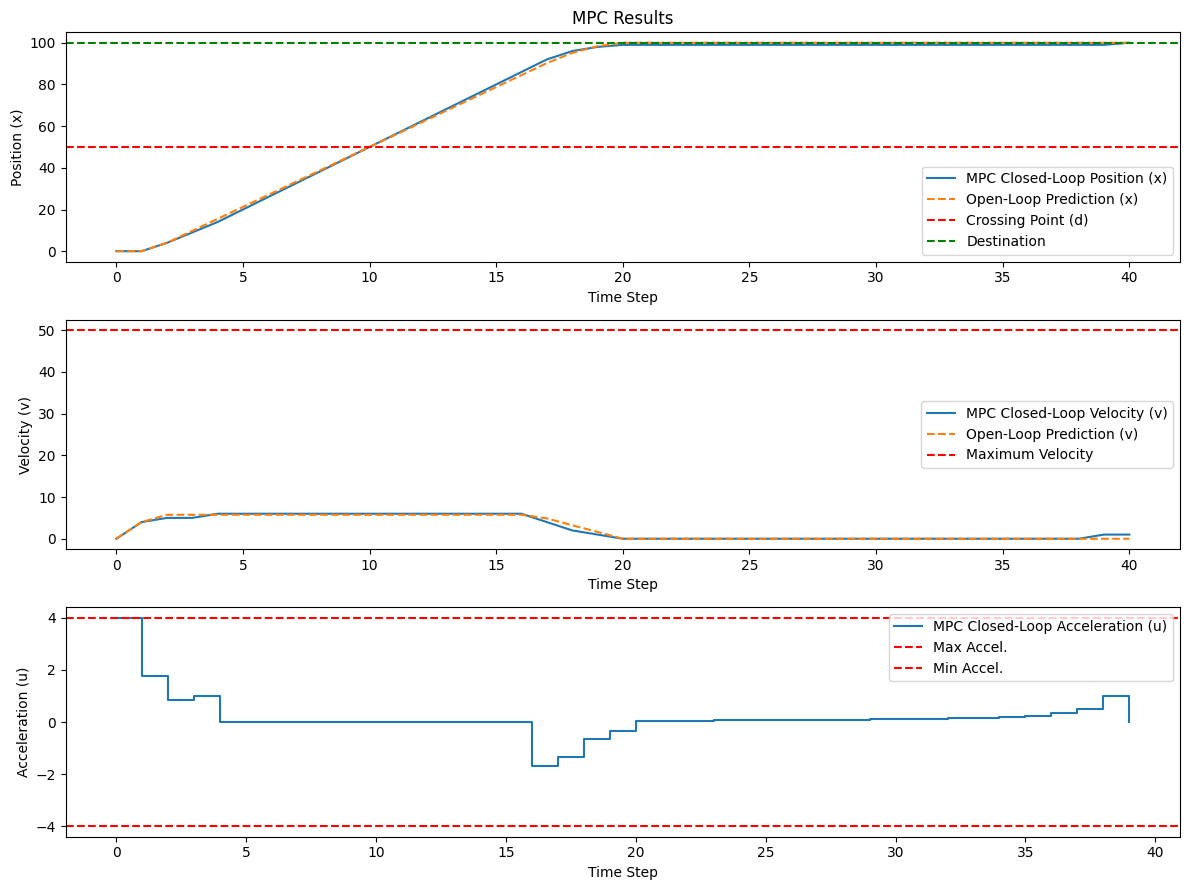

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

zbar0 = np.array([0, 0])
time_horizon = 40
N = 40

positions = []
velocities = []
accelerations = []
open_loop_traj = None

for t in range(time_horizon):
    xOpt, uOpt, feas = cftoc(zbar0, t, comfort)

    if not feas:
        print(f"No feasible solution found at time step {t}.")
        break

    if t == 0:
        open_loop_traj = xOpt

    u_t = uOpt[0, 0]

    positions.append(zbar0[0])
    velocities.append(zbar0[1])
    accelerations.append(u_t)

    zbar0[0] = xOpt[0, 1]
    zbar0[1] = xOpt[1, 1]

positions.append(xOpt[0, 1])
velocities.append(xOpt[1, 1])


print(positions)
plt.figure(figsize=(12, 9))

plt.subplot(3, 1, 1)
plt.plot(positions, label="MPC Closed-Loop Position (x)")
if open_loop_traj is not None:
    plt.plot(range(N+1), open_loop_traj[0], '--', label="Open-Loop Prediction (x)")
plt.axhline(d_crossing, color='r', linestyle='--', label="Crossing Point (d)")
plt.axhline(destination, color='g', linestyle='--', label="Destination")
plt.title("MPC Results")
plt.xlabel("Time Step")
plt.ylabel("Position (x)")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(velocities, label="MPC Closed-Loop Velocity (v)")
if open_loop_traj is not None:
    plt.plot(range(N+1), open_loop_traj[1], '--', label="Open-Loop Prediction (v)")
plt.axhline(v_max, color='r', linestyle='--', label="Maximum Velocity")
plt.xlabel("Time Step")
plt.ylabel("Velocity (v)")
plt.legend()

plt.subplot(3, 1, 3)
plt.step(range(len(accelerations)), accelerations, label="MPC Closed-Loop Acceleration (u)", where='post')
plt.axhline(a_max, color='r', linestyle='--', label="Max Accel.")
plt.axhline(-a_max, color='r', linestyle='--', label="Min Accel.")
plt.xlabel("Time Step")
plt.ylabel("Acceleration (u)")
plt.legend()

plt.tight_layout()
plt.show()


Visualising Simulaiton

<ipython-input-7-0010a46ea015>:81: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  vehicle_point.set_data(vehicle_x, vehicle_y)
<ipython-input-7-0010a46ea015>:82: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pedestrian_point.set_data(pedestrian_x_pos, pedestrian_y_pos)


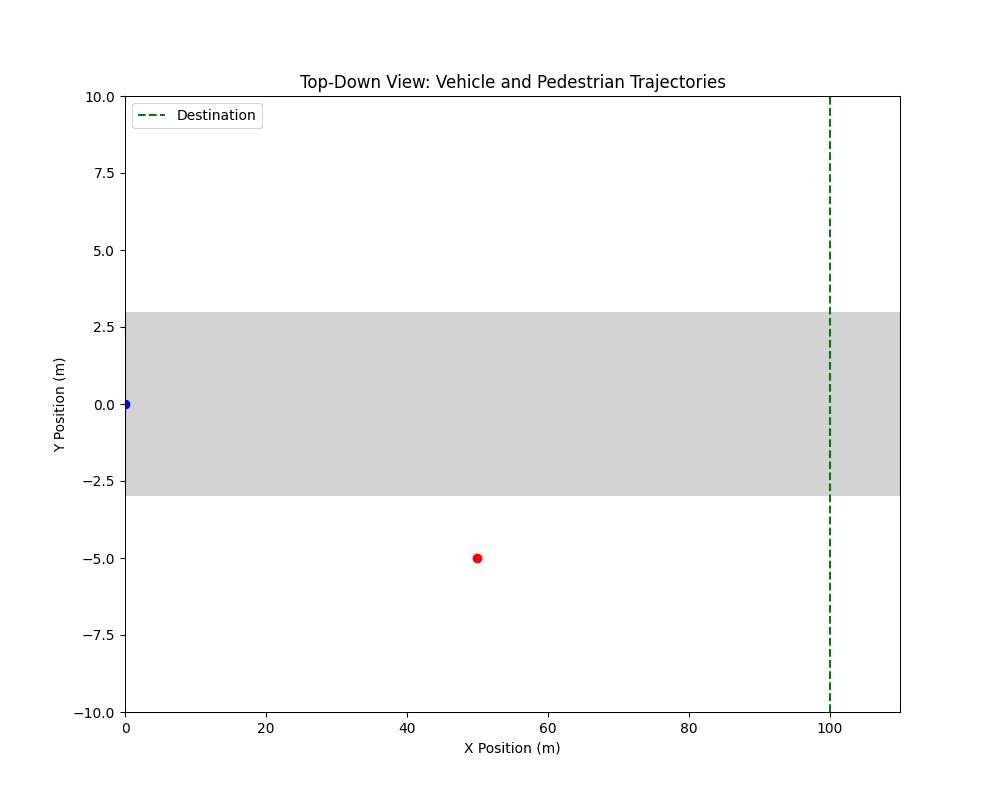

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Image

# Convert simulation data to numpy arrays
vehicle_positions = np.array(positions)
vehicle_velocities = np.array(velocities)
vehicle_accelerations = np.array(accelerations)

# Pedestrian parameters
ped_start_x = d_crossing
ped_start_y = -5
ped_speed = 1.5
ped_time_steps = len(vehicle_positions)

# Generate pedestrian positions
#pedestrian_y = np.array([ped_start_y + ped_speed * t for t in range(ped_time_steps)])
#pedestrian_x = np.full(ped_time_steps, ped_start_x)

t_crossing = 10  # The pedestrian should stand still for 10 time steps (seconds)
ped_time_steps = len(vehicle_positions)

# Original arrays:
pedestrian_y_original = np.array([ped_start_y + ped_speed * t for t in range(ped_time_steps)])
pedestrian_x_original = np.full(ped_time_steps, ped_start_x)

# Padding arrays (the pedestrian does not move during the padding period)
padding_y = np.full(t_crossing, ped_start_y)
padding_x = np.full(t_crossing, ped_start_x)

# Concatenate the padding arrays with the original arrays
pedestrian_y = np.concatenate([padding_y, pedestrian_y_original])
pedestrian_x = np.concatenate([padding_x, pedestrian_x_original])



# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Top-Down View: Vehicle and Pedestrian Trajectories')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_xlim(0, destination + 10)
ax.set_ylim(-10, 10)

# Add a gray rectangular patch to simulate a road or pavement
import matplotlib.patches as patches
road_rect = patches.Rectangle(
    (0, -3),               # bottom-left corner
    destination + 10,       # width
    6,                      # height
    facecolor='lightgray',
    edgecolor='none',
    zorder=0
)
ax.add_patch(road_rect)

# Draw vertical lines for crossing and destination
#ax.axvline(d_crossing, color='r', linestyle='--', label='Crossing Point')
ax.axvline(destination, color='g', linestyle='--', label='Destination')
ax.legend()

vehicle_point, = ax.plot([], [], 'bo', label='Vehicle')
pedestrian_point, = ax.plot([], [], 'ro', label='Pedestrian')

# Plot trajectories
#ax.plot(vehicle_positions, np.zeros_like(vehicle_positions), 'b--', alpha=0.5)
#ax.plot(pedestrian_x, pedestrian_y, 'r--', alpha=0.5)

def init():
    vehicle_point.set_data([], [])
    pedestrian_point.set_data([], [])
    return vehicle_point, pedestrian_point

def animate(t):
    vehicle_x = vehicle_positions[t]
    vehicle_y = 0  # Assuming vehicle moves along X-axis
    pedestrian_x_pos = pedestrian_x[t]
    pedestrian_y_pos = pedestrian_y[t]

    vehicle_point.set_data(vehicle_x, vehicle_y)
    pedestrian_point.set_data(pedestrian_x_pos, pedestrian_y_pos)
    return vehicle_point, pedestrian_point

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(vehicle_positions),
                               interval=500, blit=True)


anim.save('vehicle_crossing_animation.gif', writer='imagemagick', fps=24)
plt.close(fig)

Image(filename='vehicle_crossing_animation.gif')


FileNotFoundError: [Errno 2] No such file or directory: '/content/assets/vehicle_icon.png'

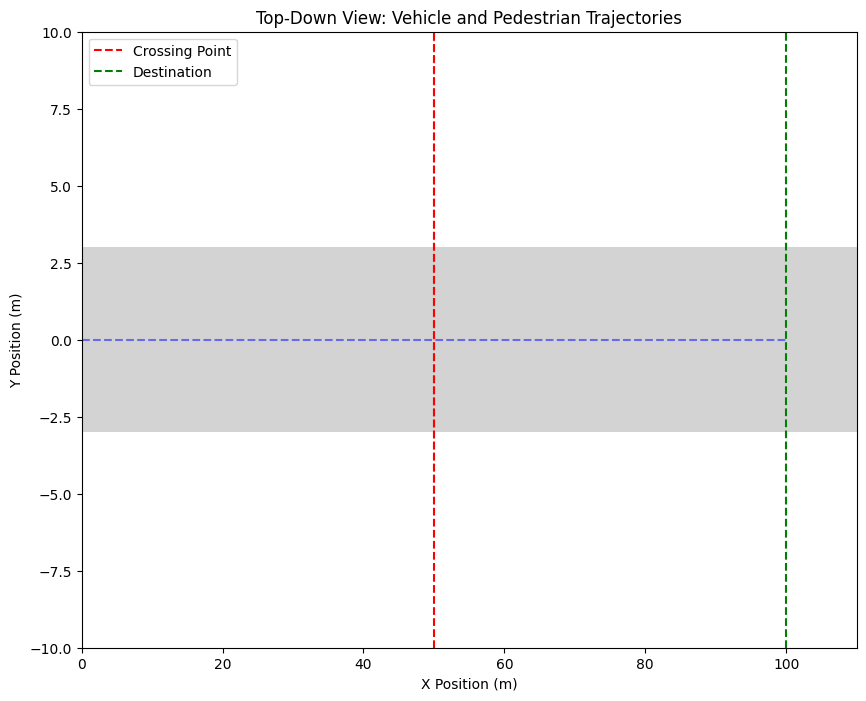

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Convert simulation data to numpy arrays
vehicle_positions = np.array(positions)
vehicle_velocities = np.array(velocities)
vehicle_accelerations = np.array(accelerations)

# Pedestrian parameters
ped_start_x = d_crossing
ped_start_y = -5
ped_speed = 1.5
ped_time_steps = len(vehicle_positions)

t_crossing = 10  # The pedestrian should stand still for 10 time steps (seconds)
ped_time_steps = len(vehicle_positions)

# Original arrays:
pedestrian_y_original = np.array([ped_start_y + ped_speed * t for t in range(ped_time_steps)])
pedestrian_x_original = np.full(ped_time_steps, ped_start_x)

# Padding arrays (the pedestrian does not move during the padding period)
padding_y = np.full(t_crossing, ped_start_y)
padding_x = np.full(t_crossing, ped_start_x)

# Concatenate the padding arrays
pedestrian_y = np.concatenate([padding_y, pedestrian_y_original])
pedestrian_x = np.concatenate([padding_x, pedestrian_x_original])

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Top-Down View: Vehicle and Pedestrian Trajectories')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_xlim(0, destination + 10)
ax.set_ylim(-10, 10)
ax.axvline(d_crossing, color='r', linestyle='--', label='Crossing Point')
ax.axvline(destination, color='g', linestyle='--', label='Destination')
ax.legend()

# Road background (optional)
import matplotlib.patches as patches
road_rect = patches.Rectangle(
    (0, -3),               # bottom-left corner
    destination + 10,       # width
    6,                      # height
    facecolor='lightgray',
    edgecolor='none',
    zorder=0
)
ax.add_patch(road_rect)

# Optional: Plot trajectories as lines
ax.plot(vehicle_positions, np.zeros_like(vehicle_positions), 'b--', alpha=0.5)
ax.plot(pedestrian_x, pedestrian_y, 'r--', alpha=0.5)

# Load icons
vehicle_icon = plt.imread('/content/assets/vehicle_icon.png')   # Replace with your icon file
pedestrian_icon = plt.imread('/content/assets/pedestrian_icon.png')  # Replace with your icon file

# Create OffsetImage objects
vehicle_img = OffsetImage(vehicle_icon, zoom=0.1)
pedestrian_img = OffsetImage(pedestrian_icon, zoom=0.1)

# Create AnnotationBbox objects at initial positions
vehicle_ab = AnnotationBbox(vehicle_img, (vehicle_positions[0], 0), frameon=False)
pedestrian_ab = AnnotationBbox(pedestrian_img, (pedestrian_x[0], pedestrian_y[0]), frameon=False)

ax.add_artist(vehicle_ab)
ax.add_artist(pedestrian_ab)

def init():
    # Nothing special to initialize since AnnotationBbox is already placed
    return vehicle_ab, pedestrian_ab

def animate(t):
    vehicle_x = vehicle_positions[t]
    vehicle_y = 0  # Assuming vehicle moves along X-axis
    pedestrian_x_pos = pedestrian_x[t]
    pedestrian_y_pos = pedestrian_y[t]

    # Update positions
    vehicle_ab.xy = (vehicle_x, vehicle_y)
    pedestrian_ab.xy = (pedestrian_x_pos, pedestrian_y_pos)
    return vehicle_ab, pedestrian_ab

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(vehicle_positions),
                               interval=500, blit=True)

anim.save('vehicle_crossing_animation.gif', writer='imagemagick', fps=24)
plt.close(fig)

Image(filename='vehicle_crossing_animation.gif')
